# Setup

## >>> data randomly generated

In [72]:
import pandas as pd
import numpy as np

# Set seed for reproducibility
np.random.seed(42)

# Create a dataset for 100 days
days = pd.date_range(start="2024-01-01", periods=100, freq="D")
demand = np.random.randint(50, 150, size=100)  # Random demand between 50 and 150 units
rail_lead_time = np.random.randint(3, 26, size=100)  # Random demand between 50 and 150 units
probability_of_penalty = np.random.uniform(0, 1, size=100)  # Random demand between 0 and 1 for 100 units

data = pd.DataFrame({
    "date": days,
    "demand": demand,
    "rail_lead_time": rail_lead_time,
    "penalty": probability_of_penalty
})

# Display the first 5 rows
print(data.head())

        date  demand  rail_lead_time   penalty
0 2024-01-01     101              15  0.253915
1 2024-01-02     142              11  0.246876
2 2024-01-03      64              17  0.696304
3 2024-01-04     121              15  0.712271
4 2024-01-05     110               3  0.148087


## + define distribution object

In [83]:
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

class Distribution:
    def __init__(self, df, column_name):
        self.df = df
        self.column_name = column_name
        self.sample_size = df[column_name].count()  # Count non-null values
        self.mean = df[column_name].mean()
        self.variance = df[column_name].var()
        self.standard_deviation = df[column_name].std()
        self.percent_std = (self.standard_deviation / self.mean) * 100  # Percentage Standard Deviation
        self.skewness = skew(df[column_name])
        self.kurtosis = kurtosis(df[column_name])
        self.print_moments()
        
    def __str__(self):
        return f"{self.column_name}"

    def __repr__(self):
        return f"{self.column_name}"

    def print_moments(self):
        print(f"{self.column_name} Descriptive Statistics")
        
        # moments
        print(f"Mean (1st moment): {self.mean}")
        print(f"Variance (2nd moment): {self.variance}")
        print(f"Skewness (3rd moment): {self.skewness}")
        print(f"Kurtosis (4th moment): {self.kurtosis}")
        print("")
        # additional statistics
        print(f"Standard Deviation: {self.standard_deviation}")
        print(f"Percentage Std (relative to mean): {self.percent_std:.2f}%")
        print('_____')
        print('')

    def plot_histogram(self, bins=20):
        self.df[self.column_name].plot(kind='hist', rwidth=0.8, bins=bins, alpha=0.7, color='skyblue')
        plt.xlabel(self.column_name)
        plt.ylabel('Frequency')
        plt.title(f'Histogram of {self.column_name}')
        plt.grid(True)
        plt.show()

    def plot_line_chart(self, x_column, window=20):
        if x_column not in self.df.columns:
            print(f"Error: '{x_column}' not found in DataFrame.")
            return

        # Calculate rolling mean and standard deviation
        rolling_mean = self.df[self.column_name].rolling(window=window).mean()
        rolling_std = self.df[self.column_name].rolling(window=window).std()

        # Calculate Bollinger Bands
        upper_band = rolling_mean + (2 * rolling_std)
        lower_band = rolling_mean - (2 * rolling_std)

        # Plot line chart with Bollinger Bands
        plt.figure(figsize=(10, 6))
        plt.plot(self.df[x_column], self.df[self.column_name], label=self.column_name, marker='o', markersize=4, linewidth=1)
        plt.plot(self.df[x_column], rolling_mean, label='Rolling Mean', linestyle='--', color='orange')
        plt.plot(self.df[x_column], upper_band, label='Upper Band (Bollinger)', linestyle='--', color='green')
        plt.plot(self.df[x_column], lower_band, label='Lower Band (Bollinger)', linestyle='--', color='red')

        plt.fill_between(self.df[x_column], lower_band, upper_band, color='gray', alpha=0.2)

        plt.xlabel(x_column)
        plt.ylabel(self.column_name)
        plt.title(f'{self.column_name} with Bollinger Bands')
        plt.legend(loc='best')
        plt.grid(True)
        plt.show()

## + define dist combined uncertainty model

## initializing 2 distributions

In [111]:
dist__demand = Distribution(data, 'demand')
dist__lead_time = Distribution(data, 'rail_lead_time')
# dist__penalty = Distribution(data, 'penalty')

demand Descriptive Statistics
Mean (1st moment): 100.54
Variance (2nd moment): 865.887272727273
Skewness (3rd moment): -0.21192595125599706
Kurtosis (4th moment): -1.1486413092477343

Standard Deviation: 29.42596256245958
Percentage Std (relative to mean): 29.27%
_____

rail_lead_time Descriptive Statistics
Mean (1st moment): 12.55
Variance (2nd moment): 42.00757575757574
Skewness (3rd moment): 0.3227708826077409
Kurtosis (4th moment): -0.8789285467455801

Standard Deviation: 6.481325154439927
Percentage Std (relative to mean): 51.64%
_____



## + adding combined gaussian samples to df

### + distribution mesh model

In [117]:
import itertools

def model__distribution_mesh(distribution_pair: tuple): #TODO: need to handle 2 pair
        a, b = distribution_pair
    
        # Calculate the three variance terms
        term_1 = a.mean * b.variance
        term_2 = b.mean * a.variance
        term_3 = a.variance * b.variance

        # Calculate the combined mean and variance
        combined_mean = a.mean * b.mean
        combined_variance = term_1 + term_2 + term_3
        
        # Output the results for each pair
        print(f"Distributions: {a} & {b}")
        print(f"Combined Mean: {combined_mean}")
        print(f"Combined Variance: {combined_variance}\n")
        
        return combined_mean, combined_variance, a.sample_size

### + distribution mesh wrapper function

In [118]:
def model_wrapper__distribution_mesh(list_distributions, df):
    # Generate all unique pairs of distributions
    unique_pairs = list(itertools.combinations(list_distributions, 2))
    
    for distribution_combination in unique_pairs:
        
        combined_mean, combined_variance, sample_size = model__distribution_mesh(distribution_combination)
        
        # Generate a sample dataset with the combined mean and variance
        combined_std = np.sqrt(combined_variance)  # Standard deviation is sqrt(variance)
        combined_gaussian_generated_data = np.random.normal(loc=combined_mean, scale=combined_std, size=sample_size)
        print(f"Skewness: {skew(combined_gaussian_generated_data)}")
        print(f"Kurtosis: {kurtosis(combined_gaussian_generated_data) + 3}")  # Adding 3 for total kurtosis
        
        df[f"{distribution_combination}__gaussian_generated"] = combined_gaussian_generated_data
        
        print('____')
        print('')

model_wrapper__distribution_mesh([
    dist__demand,
    dist__lead_time,
    # dist__penalty
], data)

Distributions: demand & rail_lead_time
Combined Mean: 1261.777
Combined Variance: 51464.1521460055

Skewness: -0.36993427416546537
Kurtosis: 3.3283888527906664
____



### --- debug

In [103]:
data.head()

,date,demand,rail_lead_time,penalty,"(demand, rail_lead_time)__gaussian_generated","(demand, penalty)__gaussian_generated","(rail_lead_time, penalty)__gaussian_generated"
0,2024-01-01,101,15,0.253915,1562.773162,51.440828,-0.019256
1,2024-01-02,142,11,0.246876,1317.816753,58.002581,12.571831
2,2024-01-03,64,17,0.696304,1384.082955,73.858836,10.762786
3,2024-01-04,121,15,0.712271,1339.278020,34.498048,3.954635
4,2024-01-05,110,3,0.148087,1067.698159,30.464258,7.279757


In [102]:
[print(col) for col in data.columns if "generated" in col]

(demand, rail_lead_time)__gaussian_generated
(demand, penalty)__gaussian_generated
(rail_lead_time, penalty)__gaussian_generated


[None, None, None]

(demand, rail_lead_time)__gaussian_generated Descriptive Statistics
Mean (1st moment): 1291.7369891130181
Variance (2nd moment): 52551.710825497095
Skewness (3rd moment): 0.013411726676903058
Kurtosis (4th moment): 0.06508773518700028

Standard Deviation: 229.24159924738157
Percentage Std (relative to mean): 17.75%
_____



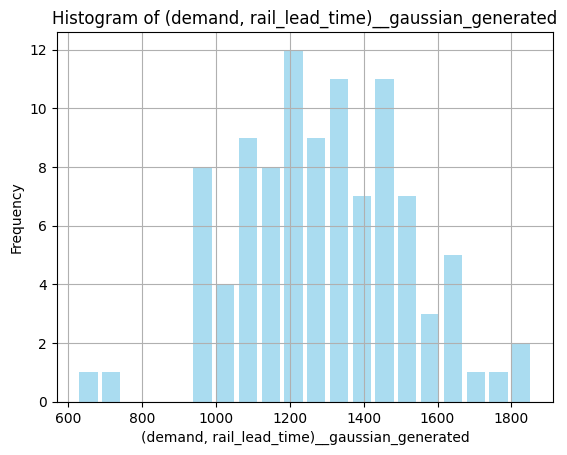

(demand, penalty)__gaussian_generated Descriptive Statistics
Mean (1st moment): 54.81781038870548
Variance (2nd moment): 565.9941876389462
Skewness (3rd moment): 0.17500352600115754
Kurtosis (4th moment): -0.016576877686864222

Standard Deviation: 23.79063235054811
Percentage Std (relative to mean): 43.40%
_____



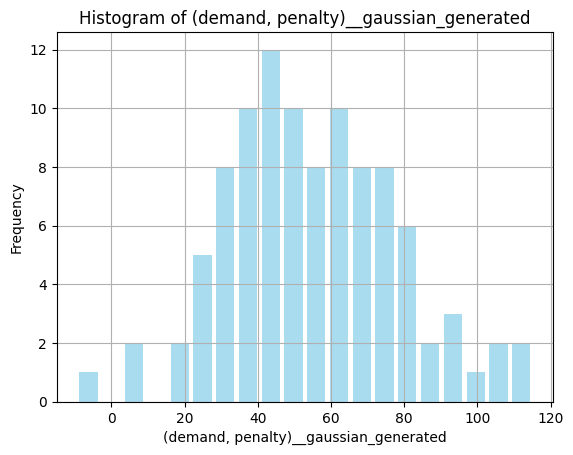

(rail_lead_time, penalty)__gaussian_generated Descriptive Statistics
Mean (1st moment): 7.369518474230167
Variance (2nd moment): 22.691907023924877
Skewness (3rd moment): 0.43550652694093434
Kurtosis (4th moment): -0.3744108665665462

Standard Deviation: 4.763602315887093
Percentage Std (relative to mean): 64.64%
_____



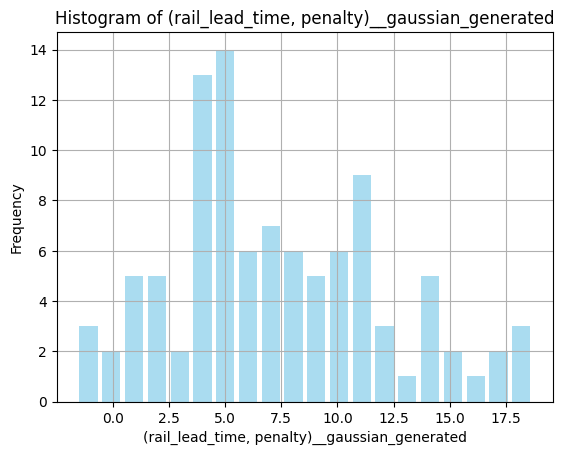

In [106]:
dist__demand_rail_lead_time = Distribution(data, '(demand, rail_lead_time)__gaussian_generated')
dist__demand_penalty = Distribution(data, '(demand, penalty)__gaussian_generated')
dist__rail_lead_time_penalty = Distribution(data, '(rail_lead_time, penalty)__gaussian_generated')

dist__demand_rail_lead_time.plot_histogram()
dist__demand_penalty.plot_histogram()
dist__rail_lead_time_penalty.plot_histogram()

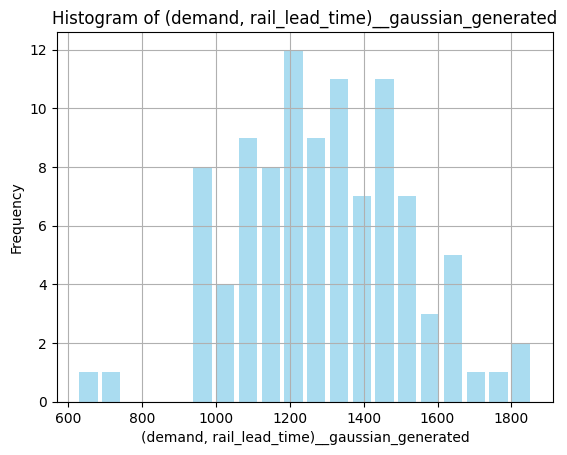

In [105]:
dist__demand_rail_lead_time.plot_histogram()